In [1]:
import re
from IPython.display import display, Markdown

import ebooklib
from ebooklib import epub
import nltk
from bs4 import BeautifulSoup
import altair as alt
import pandas as pd

In [2]:
books = [
    '../books/free/Great Expectations - Charles Dickens.epub',
    '../books/unfree/The Overstory - Richard Powers.epub'
]

book_choice = books[1]
book_choice

'../books/unfree/The Overstory - Richard Powers.epub'

In [3]:
def get_section_header(text):
    return text.strip().split("\n")[0]

In [4]:
book = epub.read_epub(book_choice)
items = book.get_items_of_type(ebooklib.ITEM_DOCUMENT)

d = {}
for item in items:
    
    name = item.get_name()
    id_ = item.get_id()
    
    content = item.get_body_content()
    soup = BeautifulSoup(content, features="lxml")
    text = soup.get_text()
    
    header = get_section_header(text)
    
    d[id_] = dict(
        section_name=name,
        section_id=id_,
        text=text,
        header=header,
    )

In [5]:
# ids
sections = list(d.keys())
sections

['Cover',
 'toc',
 'title',
 'ch1',
 'ch2',
 'ch3',
 'ch4',
 'ch5',
 'ch6',
 'ch7',
 'ch8',
 'ch9',
 'ch10',
 'ch11',
 'ch12',
 'also',
 'ded',
 'epi',
 'copy']

In [6]:
# names
[x['section_name'] for x in d.values()]

['cover.xhtml',
 'toc.xhtml',
 'title.xhtml',
 'ch1.xhtml',
 'ch2.xhtml',
 'ch3.xhtml',
 'ch4.xhtml',
 'ch5.xhtml',
 'ch6.xhtml',
 'ch7.xhtml',
 'ch8.xhtml',
 'ch9.xhtml',
 'ch10.xhtml',
 'ch11.xhtml',
 'ch12.xhtml',
 'also.xhtml',
 'ded.xhtml',
 'epi.xhtml',
 'copy.xhtml']

In [7]:
def show_preview(i):
    section = sections[i]
    print("id:", section)
    print("name:", d[section]['section_name'])
    print("header:", d[section]['header'])
    
    text = d[section]['text']
    print("="*50)
    display(text[:200])
    print("...")
    display(text[-200:])

In [8]:
# show_preview(4)

## Get Main Content

In [9]:
content = {}
for section, v in d.items():
    if "ch" in section:
        chapter_num = int(''.join(filter(str.isdigit, v['section_id'])))
        title = f"{chapter_num:02} - {v['header']}"
        content[title] = v

In [10]:
content_keys = list(content.keys())
content_keys

['01 - ROOTS',
 '02 - NICHOLAS HOEL',
 '03 - MIMI MA',
 '04 - ADAM APPICH',
 '05 - RAY BRINKMAN AND DOROTHY CAZALY',
 '06 - DOUGLAS PAVLICEK',
 '07 - NEELAY MEHTA',
 '08 - PATRICIA WESTERFORD',
 '09 - OLIVIA VANDERGRIFF',
 '10 - TRUNK',
 '11 - CROWN',
 '12 - SEEDS']

In [11]:
k = content_keys[0]
content[k].keys()

dict_keys(['section_name', 'section_id', 'text', 'header'])

## Word Counts

In [12]:
chapters = []
counts = []

for title, v in content.items():
    chapters.append(title)
    counts.append(len(v['text']))

data = pd.DataFrame(dict(
    chapter=chapters,
    word_count=counts
))

data

,chapter,word_count
0,01 - ROOTS,2360
1,02 - NICHOLAS HOEL,40451
2,03 - MIMI MA,44610
3,04 - ADAM APPICH,32358
4,05 - RAY BRINKMAN AND DOROTHY CAZALY,16053
5,06 - DOUGLAS PAVLICEK,38900
6,07 - NEELAY MEHTA,42932
7,08 - PATRICIA WESTERFORD,69615
8,09 - OLIVIA VANDERGRIFF,15499
9,10 - TRUNK,386394


## Word Counts by Chapter

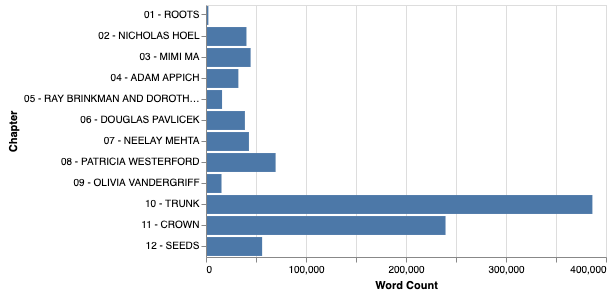

In [13]:
chart = alt.Chart(data).mark_bar().encode(
    alt.X('word_count', title='Word Count'),
    alt.Y('chapter', title='Chapter'),
    tooltip=['chapter', 'word_count'],
).interactive()

display(Markdown('## Word Counts by Chapter'))
display(chart)

In [14]:
# chart.save('out/html/word_counts.html')

# chart.background = 'white'
# chart.save('out/png/word_counts.png', scale_factor=2.0)

## Freq Words

In [50]:
import operator
from functools import reduce

from nltk.corpus import stopwords
from collections import Counter

In [51]:
stop_words = set(stopwords.words('english')) 

def get_freq_words(section_id):
    text = d[section_id]['text']
    
    # tokenize
    word_tokens = nltk.word_tokenize(text)

    # remove punctuation
    words = [word.lower() for word in word_tokens if word.isalpha()]

    # remove stop words
    filtered_words = [w for w in words if not w in stop_words]
    
    c = Counter(filtered_words)
    return c.most_common(5)

In [52]:
counts = []
for title, v in content.items():
    res = get_freq_words(v['section_id'])
    res = [(*t, title) for t in res]
    counts.append(res)

counts_joined = reduce(operator.add, counts)

data = pd.DataFrame(counts_joined, columns=['word', 'count', 'chapter'])
data.sample(n=5)

,word,count,chapter
45,like,286,10 - TRUNK
43,back,9,09 - OLIVIA VANDERGRIFF
52,back,127,11 - CROWN
26,one,26,06 - DOUGLAS PAVLICEK
21,ray,13,05 - RAY BRINKMAN AND DOROTHY CAZALY


## Most Frequent Words by Chapter

Counts of 5 most common words (excluding ["stop words"](https://en.wikipedia.org/wiki/Stop_words)) from each chapter throughout the book.

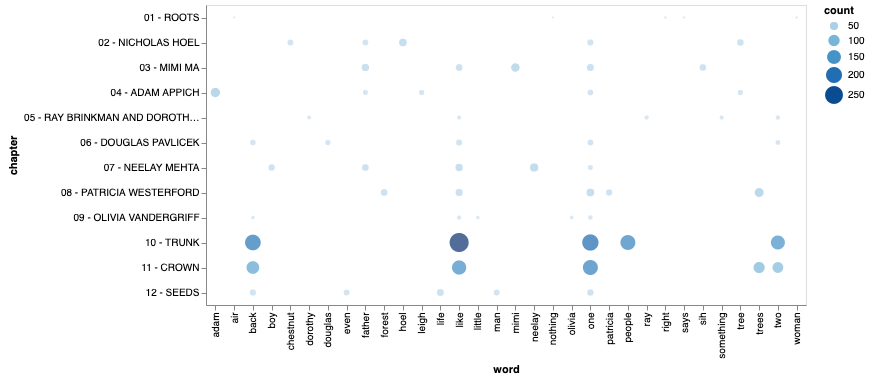

In [53]:
chart = alt.Chart(data).mark_circle().encode(
    x='word',
    y='chapter',
    size='count',
    color='count',
    tooltip=['word', 'chapter', 'count'],
).properties(height=300, width=600).interactive()

display(Markdown('## Most Frequent Words by Chapter'))
display(Markdown(
    'Counts of 5 most common words '
    '(excluding ["stop words"](https://en.wikipedia.org/wiki/Stop_words)), '
    'from each chapter throughout the book.'))

display(chart)

In [19]:
# chart.save('out/html/freq_words.html')

# chart.background = 'white'
# chart.save('out/png/freq_words.png', scale_factor=2.0)

## Characters

In [20]:
charcters = [
    'Nicholas Hoel',
    'Mimi Ma',
    'Adam Appich',
    'Ray Brinkman',
    'Dorothy Cazaly',
    'Douglas Pavlicek',
    'Neelay Mehta',
    'Patricia Westerford',
    'Olivia Vandergriff',
]

In [21]:
def eitherfy(name):
    first, last = name.split()
    return f"\\b{first}\\b|\\b{last}\\b"

In [22]:
def count_char_refs(text):
    counts = []
    for name in charcters:
        exp = eitherfy(name)
        count = len(re.findall(exp, text))
        counts.append((name, count))
    return counts

In [23]:
chapter_counts = []
for title, v in content.items():
    res = count_char_refs(v['text'])
    res = [(*t, title) for t in res]
    chapter_counts.append(res)
    
counts_joined = reduce(operator.add, chapter_counts)

data = pd.DataFrame(counts_joined, columns=['character', 'count', 'chapter'])
data.sample(n=5)

,character,count,chapter
89,Olivia Vandergriff,72,10 - TRUNK
90,Nicholas Hoel,9,11 - CROWN
15,Neelay Mehta,0,02 - NICHOLAS HOEL
72,Nicholas Hoel,0,09 - OLIVIA VANDERGRIFF
91,Mimi Ma,58,11 - CROWN


## Characters references across chapters

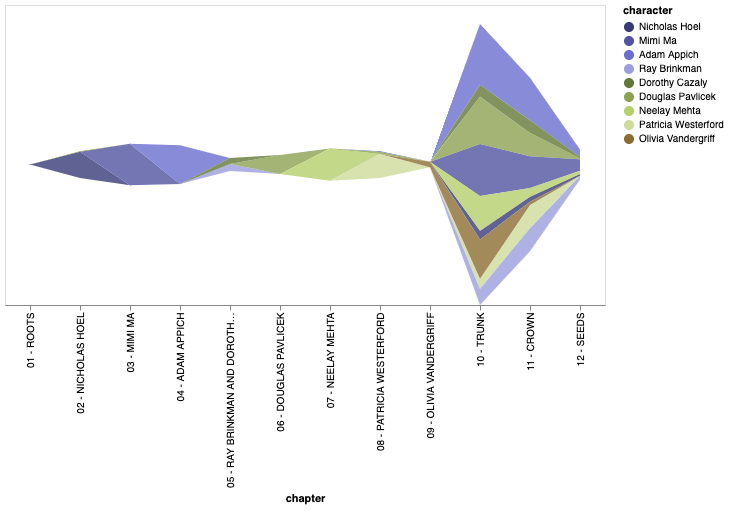

In [24]:
chart = alt.Chart(data).mark_area(fillOpacity=0.8).encode(
    alt.X('chapter'),
    alt.Y('count', stack='center', axis=None),
    alt.Color(
        'character',
        scale=alt.Scale(scheme='category20b'),
        sort=charcters
    ),
    tooltip=['character', 'chapter', 'count'],
).properties(height=300, width=600).interactive()

display(Markdown('## Characters references across chapters'))
display(chart)

In [25]:
# chart.save('out/html/characters.html')

# chart.background = 'white'
# chart.save('out/png/characters.png', scale_factor=2.0)

In [26]:
# chart = alt.Chart(data).mark_area().encode(
#     x="chapter",
#     y="count",
#     color="character",
#     row='character'
# ).properties(height=50, width=400)

# chart

## Trees

In [27]:
trees = [
    'alder',
    'ash',
    'birch',
    'chestnut',
    'elm',
    'fig',
    'fir',
    'fusang',
    'hemlock',
    'lote',
    'maple',
    'mulberry',
    'oak',
    'pine',
    'redwood',
    'silk',
    'walnut',
    'willow'
]

In [28]:
def count_refs(text):
    counts = []
    for name in trees:
        count = len(re.findall(name, text, flags=re.IGNORECASE))
        counts.append((name, count))
    return counts

In [29]:
tree_counts = []

for title, v in content.items():
    res = count_refs(v['text'])
    res = [(*t, title) for t in res]
    tree_counts.append(res)
    
counts_joined = reduce(operator.add, tree_counts)

data = pd.DataFrame(counts_joined, columns=['tree', 'count', 'chapter'])
data.sample(n=5)

,tree,count,chapter
6,fir,1,01 - ROOTS
138,oak,7,08 - PATRICIA WESTERFORD
137,mulberry,0,08 - PATRICIA WESTERFORD
212,redwood,4,12 - SEEDS
213,silk,1,12 - SEEDS


In [30]:
data.pivot_table(columns='tree', values='count', aggfunc='sum')

tree,alder,ash,birch,chestnut,elm,fig,fir,fusang,hemlock,lote,maple,mulberry,oak,pine,redwood,silk,walnut,willow
count,5,204,10,68,25,113,390,7,12,3,44,35,59,94,41,18,13,7


## Tree references across chapters

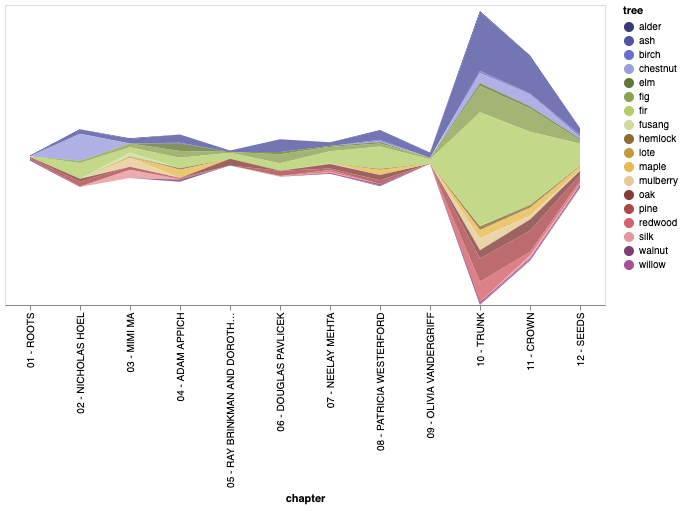

In [31]:
chart = alt.Chart(data).mark_area(fillOpacity=0.8).encode(
    alt.X('chapter'),
    alt.Y('count', stack='center', axis=None),
    alt.Color(
        'tree',
        scale=alt.Scale(scheme='category20b'),
        sort=charcters
    ),
    tooltip=['tree', 'chapter', 'count'],
).properties(height=300, width=600).interactive()

display(Markdown('## Tree references across chapters'))
display(chart)

In [32]:
# chart.save('out/html/trees.html')

# chart.background = 'white'
# chart.save('out/png/trees.png', scale_factor=2.0)

In [33]:
# all_text = ' '.join([v['text'] for v in content.values()])
# text = all_text

In [34]:
# for match in re.finditer(r"\btree\b", text):
#     print(match)
#     start = match.start() - 25
#     end = match.end() + 25
    
#     print("...", text[start:end], "...")
#     print()

## More NLTK

#### Note about stop words

Issue with contractions. Maybe alternative tokenizer better?

In [35]:
s = "I can't go. I don't want to."
tokens = nltk.word_tokenize(s)
tokens

['I', 'ca', "n't", 'go', '.', 'I', 'do', "n't", 'want', 'to', '.']

In [36]:
tagged = nltk.pos_tag(tokens)
entities = nltk.chunk.ne_chunk(tagged)

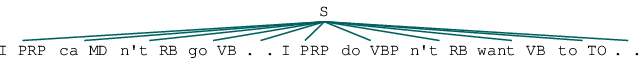

In [37]:
entities

In [38]:
text = d['ch3']['text']

In [39]:
sentence = text.split("\n\n")[1].split(".")[0]
sentence

'THE DAY IN 1948 when Ma Sih Hsuin gets his third-class ticket for a crossing to San Francisco, his father starts addressing him in English'

In [40]:
tokens = nltk.word_tokenize(sentence)
tagged = nltk.pos_tag(tokens)
entities = nltk.chunk.ne_chunk(tagged)

In [41]:
tagged[:5]

[('THE', 'DT'), ('DAY', 'NNP'), ('IN', 'NNP'), ('1948', 'CD'), ('when', 'WRB')]

In [42]:
# nltk.help.upenn_tagset('NNP')

In [43]:
trees = [x for x in entities if type(x) == nltk.tree.Tree]
trees

[Tree('PERSON', [('Ma', 'NNP'), ('Sih', 'NNP'), ('Hsuin', 'NNP')]),
 Tree('GPE', [('San', 'NNP'), ('Francisco', 'NNP')]),
 Tree('GPE', [('English', 'NNP')])]

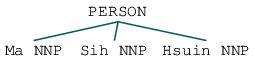

In [44]:
t = trees[0]
t

In [45]:
t.label()

'PERSON'

In [46]:
t.leaves()

[('Ma', 'NNP'), ('Sih', 'NNP'), ('Hsuin', 'NNP')]

In [47]:
# for match in re.finditer(r"\bMa\b", text):
#     print(match)
#     start = match.start() - 20
#     end = match.end() + 20
    
#     print(text[start:end])
#     print()

In [48]:
# # name = r"\bHoel\b"
# # name = r"\bMa\b"
# name = r"[19]\d\d"  # a year?

In [49]:
# for section, v in d.items():
#     print("========")
#     print(section)
#     text = v['text']
#     for match in re.finditer(name, text):
#         print(match)
#         start = match.start() - 20
#         end = match.end() + 20

#         print(text[start:end])
#         print()